# MCMC Model for Temperature Data

In [1]:
feature_data_dir = '../data/features'
processed_data_dir = '../data/processed'
media_dir = '../media'
figsize_width = 12
figsize_height = 8
output_dpi = 72

In [2]:
# Imports
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Variable setup
colors = ['#2d758c', '#cf4917', '#f9ac3d', '#758c33']
default_fig_size = (figsize_width, figsize_height)

def save_figure(f, name, dpi=output_dpi, **kwargs):
    """Helper function to save figures"""
    fpath = os.path.join(media_dir, "{}.png".format(name))
    f.savefig(fpath, dpi=dpi, **kwargs)

In [4]:
# Load data
def load_data(data_dir, filename):
    """Helper function to load data"""
    with open(os.path.join(data_dir, filename), 'rb') as fin:
        ret = pickle.load(fin)
    return ret

# - Load NASA data
nasa_tanom = load_data(processed_data_dir, 'nasa_temperature_anomaly.pkl')

# - Load our NOAA data
data_to_load = ['surface', 'aloft', 'diff']
feature_data = dict()
for nm in data_to_load:
    feature_data[nm] = load_data(feature_data_dir, 'noaa_{}_interpolated_data.pkl'.format(nm))

# - Load the Wunderground data
region_yearly_df = load_data(processed_data_dir, 'region_yearly_data.pkl')

In [5]:
# Constants
NASA_GISS_REF_VALUE = 14.0
NASA_76_STD_SURFACE = 15.0
NASA_76_STD_ALOFT = -56.5

CELSIUS_TO_KELVIN = 273.15

In [6]:
# - Get temperature anomaly data
b_monthly = True

surface_tanom = dict()
for k, v in feature_data['surface'].items():
    surface_tanom[k] = v.flatten().mean()
surface_tanom = pd.DataFrame.from_dict(surface_tanom, orient='index', columns=['Surface'])
if not b_monthly:
    surface_tanom = surface_tanom.groupby(surface_tanom.index.year).mean()

aloft_tanom = dict()
for k, v in feature_data['aloft'].items():
    aloft_tanom[k] = v.flatten().mean()
aloft_tanom = pd.DataFrame.from_dict(aloft_tanom, orient='index', columns=['Aloft'])
if not b_monthly:
    aloft_tanom = aloft_tanom.groupby(aloft_tanom.index.year).mean()

noaa_tanom = pd.concat([surface_tanom, aloft_tanom], axis=1)

if not b_monthly:
    tmp_nasa = nasa_tanom.loc[:, 'Annual Mean'].copy()
    tmp_nasa.name = 'NASA'
    all_tanom = pd.concat([tmp_nasa, noaa_tanom], axis=1).dropna()
else:
    all_tanom = noaa_tanom.copy()

all_tanom.corr()

,Surface,Aloft
Surface,1.00000,-0.85441
Aloft,-0.85441,1.00000


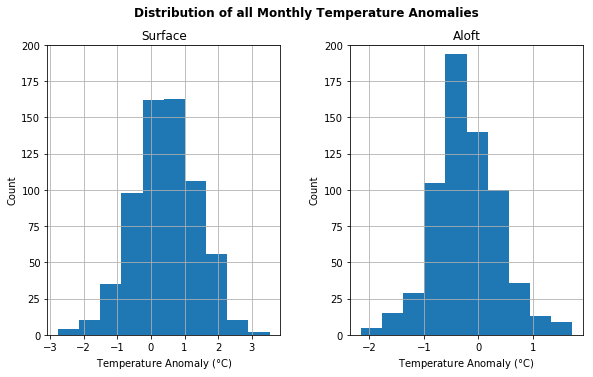

In [7]:
# - Plot
fig, axs = plt.subplots(ncols=2, figsize=(figsize_width/1.25, figsize_height/1.5))

ax = axs[0]
all_tanom.hist('Surface', ax=ax)
ax.set_ylim(0, 200)
ax.set_xlabel('Temperature Anomaly ($\degree$C)')
ax.set_ylabel('Count')

ax = axs[1]
all_tanom.hist('Aloft', ax=ax)
ax.set_ylim(0, 200)
ax.set_xlabel('Temperature Anomaly ($\degree$C)')
ax.set_ylabel('Count')

fig.suptitle('Distribution of all Monthly Temperature Anomalies', fontweight='bold')
save_figure(fig, 'surface_aloft_dist_all')
plt.show();

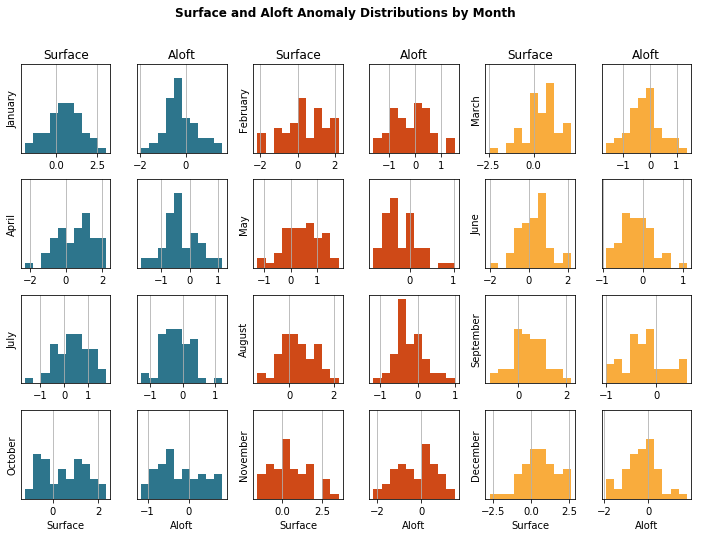

In [8]:
# - Plot individual months
fig, axs = plt.subplots(nrows=4, ncols=6, sharex=False, sharey=True, 
                        figsize=(figsize_width, figsize_height))

ks_tests = dict()
t_tests = dict()
for mon in range(1, 13):
    t_idx = np.unravel_index(mon-1, (4, 3))
    t_idx = (t_idx[0], t_idx[1]*2)
    t_axs = axs[t_idx[0]]
    
    mon_name = datetime(2000, mon, 1).strftime('%B')
    mon_data = all_tanom.loc[all_tanom.index.month == mon, :]
    
    ks_tests[mon_name] = dict()
    t_tests[mon_name] = dict()
    
    t_all_data = all_tanom.copy()
    t_all_data.loc[t_all_data.index.month == mon] = np.nan
    t_all_data.dropna(inplace=True)
    
    i_c = 0
    for col in mon_data.columns:
        _, ks_tests[mon_name][col] = stats.ks_2samp(mon_data.loc[:, col], 
                                                    t_all_data.loc[:, col])
        _, t_tests[mon_name][col] = stats.ttest_ind(mon_data.loc[:, col], 
                                                    t_all_data.loc[:, col])
        
        t_ax = t_axs[t_idx[1]+i_c]
        mon_data.hist(col, ax=t_ax, color=colors[int(t_idx[1]/2)])
        
        t_ax.set_yticks([])
        if t_idx[0] == 3:
            t_ax.set_xlabel(t_ax.get_title())
        if t_idx[0] > 0:
            t_ax.set_title('')
        
        if i_c == 0:
            t_ax.set_ylabel(mon_name)
        
        i_c += 1

fig.suptitle('Surface and Aloft Anomaly Distributions by Month', va='top', fontweight='bold')
save_figure(fig, 'surface_aloft_dist_by_month')
plt.show();

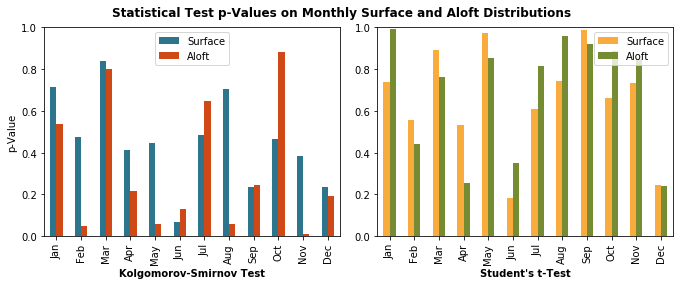

In [9]:
# - Plot ks test results
ks_df = pd.DataFrame.from_dict(ks_tests).T.loc[:, ['Surface', 'Aloft']]
ks_df.index = [x[:3] for x in ks_df.index]

tt_df = pd.DataFrame.from_dict(t_tests).T.loc[:, ['Surface', 'Aloft']]
tt_df.index = [x[:3] for x in tt_df.index]

fig, axs = plt.subplots(ncols=2, figsize=(figsize_width/1.25, figsize_height/2.0))

ax = axs[0]
ks_df.plot.bar(ax=ax, color=[colors[0], colors[1]])
ax.set_title(' ')
ax.set_ylim(0, 1)
ax.set_xlabel('Kolgomorov-Smirnov Test', fontweight='bold')
ax.set_ylabel('p-Value')

ax = axs[1]
tt_df.plot.bar(ax=ax, color=[colors[2], colors[3]])
ax.set_ylim(0, 1)
ax.set_title(' ')
ax.set_xlabel("Student's t-Test", fontweight='bold')

fig.suptitle('Statistical Test p-Values on Monthly Surface and Aloft Distributions', 
             fontweight='bold', va='top')
fig.tight_layout()
save_figure(fig, 'surface_aloft_dist_ks_pvalue_by_month')
plt.show();

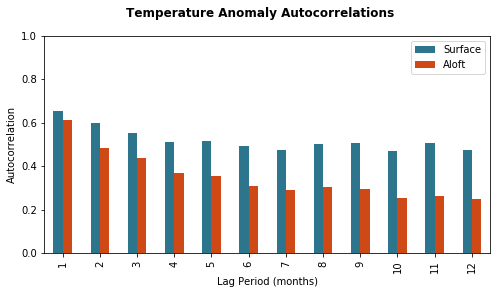

In [10]:
# - Autocorrelation
periods = list(range(1, 13))

auto_corrs = dict()
for col in all_tanom.columns:
    auto_corrs[col] = dict()
    for period in periods:
        auto_corrs[col][period] = all_tanom.loc[:, col].autocorr(period)

ac_df = pd.DataFrame.from_dict(auto_corrs)

fig, ax = plt.subplots(figsize=(figsize_width/1.5, figsize_height/2))

ac_df.plot.bar(ax=ax, color=colors[:2])
ax.axhline(0., color='black', linewidth=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Lag Period (months)')
ax.set_ylabel('Autocorrelation')

fig.suptitle('Temperature Anomaly Autocorrelations', fontweight='bold')
save_figure(fig, 'surface_aloft_all_autocorrelation')
plt.show();

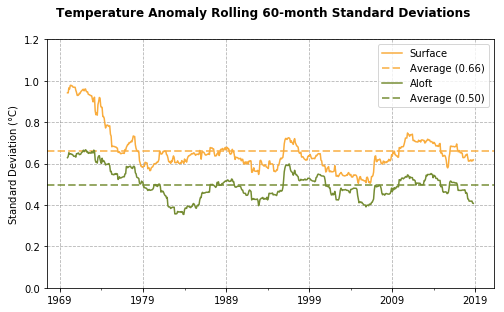

In [11]:
# - Homoskedasticity
period = 60

roll_var = all_tanom.rolling(period).std()
var_means = roll_var.mean()

fig, ax = plt.subplots(figsize=(figsize_width/1.5, figsize_height/1.75))

roll_var.loc[:, 'Surface'].plot(ax=ax, color=colors[2])
ax.axhline(var_means.loc['Surface'], color=colors[2], linestyle='--', linewidth=2.0,
           alpha=0.75, label='Average ({:.2f})'.format(var_means.loc['Surface']))
roll_var.loc[:, 'Aloft'].plot(ax=ax, color=colors[3])
ax.axhline(var_means.loc['Aloft'], color=colors[3], linestyle='--', linewidth=2.0,
           alpha=0.75, label='Average ({:.2f})'.format(var_means.loc['Aloft']))
ax.grid(True, linestyle='--', color='grey', alpha=0.6)
ax.set_ylim(0, 1.2)
ax.set_ylabel('Standard Deviation ($\degree$C)'.format(period))
ax.legend()

fig.suptitle('Temperature Anomaly Rolling {}-month Standard Deviations'.format(period), 
             fontweight='bold', va='top')
save_figure(fig, 'surface_aloft_all_rolling_std')
plt.show();

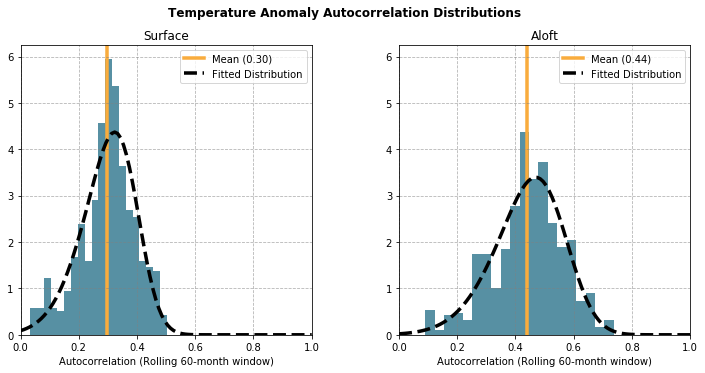

In [12]:
# - Autocorrelation distributions
period = 60

roll_acorr = all_tanom.rolling(period).apply(lambda x: x.autocorr(1), raw=False)
acorr_avg = roll_acorr.mean()
acorr_std = roll_acorr.std()

# - Fitting distributions to autocorrelation data
dist_to_use = stats.skewnorm

s_ac_params = dist_to_use.fit(roll_acorr.dropna().loc[:, 'Surface'])
s_ac_dist = dist_to_use(*s_ac_params)

a_ac_params = dist_to_use.fit(roll_acorr.dropna().loc[:, 'Aloft'])
a_ac_dist = dist_to_use(*a_ac_params)
                               
# - Plot
area_col = colors[0]
area_alpha = 0.8
fit_col = 'black'
line_col = colors[2]

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(figsize_width, figsize_height/1.5))

# -- Surface
ax = axs[0]
roll_acorr.hist('Surface', bins=20, density=True, color=area_col, alpha=area_alpha, ax=ax)
ax.axvline(acorr_avg.loc['Surface'], linestyle='-', linewidth=3.5, zorder=1,
           color=line_col, label='Mean ({:.2f})'.format(acorr_avg.loc['Surface']))
ax.set_xlim(0, 1.0)

t_x = np.linspace(0, 1.0, 100)
ax.plot(t_x, s_ac_dist.pdf(t_x), color=fit_col, linestyle='--', linewidth=3.5, 
        zorder=2, label='Fitted Distribution')

ax.grid(True, linestyle='--', color='grey', alpha=0.6)
ax.set_xlabel('Autocorrelation (Rolling {}-month window)'.format(period))
ax.legend(loc='upper right')

# -- Aloft
ax = axs[1]
roll_acorr.hist('Aloft', bins=20, density=True, color=area_col, alpha=area_alpha, ax=ax)
ax.axvline(acorr_avg.loc['Aloft'], linestyle='-', linewidth=3.5, zorder=1,
           color=line_col, label='Mean ({:.2f})'.format(acorr_avg.loc['Aloft']))
ax.set_xlim(0, 1.0)
ax.yaxis.set_tick_params(labelleft=True)

t_x = np.linspace(0, 1.0, 100)
ax.plot(t_x, a_ac_dist.pdf(t_x), color=fit_col, linestyle='--', linewidth=3.5, 
        zorder=2, label='Fitted Distribution')

ax.grid(True, linestyle='--', color='grey', alpha=0.6)
ax.set_xlabel('Autocorrelation (Rolling {}-month window)'.format(period))
ax.legend(loc='upper right')

fig.suptitle('Temperature Anomaly Autocorrelation Distributions', fontweight='bold')
save_figure(fig, 'surface_aloft_autocorrelation_dists')
plt.show();

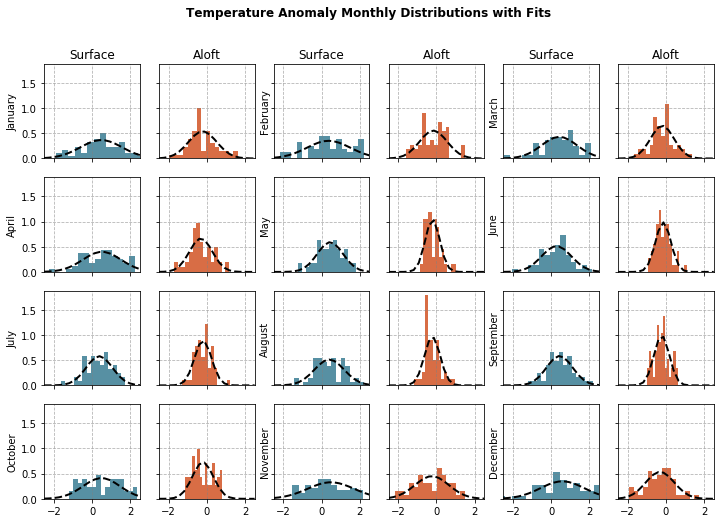

In [13]:
# - Fit monthly distributions
dist_to_use = stats.norm

# -- Plots
fig, axs = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, 
                        figsize=(figsize_width, figsize_height))

fit_params = dict()
fit_dists = dict()
for mon in range(1, 13):
    t_idx = np.unravel_index(mon-1, (4, 3))
    t_idx = (t_idx[0], t_idx[1]*2)
    t_axs = axs[t_idx[0]]
    
    mon_name = datetime(2000, mon, 1).strftime('%B')
    mon_data = all_tanom.loc[all_tanom.index.month == mon, :]

    fit_params[mon_name] = dict()
    fit_dists[mon_name] = dict()
    
    i_c = 0
    for col in mon_data.columns:
        t_ax = t_axs[t_idx[1]+i_c]
        t_data = mon_data.loc[:, col].dropna()
        
        fit_params[mon_name][col] = dist_to_use.fit(t_data)
        fit_dists[mon_name][col] = dist_to_use(*fit_params[mon_name][col])
        
        t_data.hist(ax=t_ax, color=colors[i_c], alpha=area_alpha, bins=15, density=True)
        t_ax.set_xlim(-2.5, 2.5)
        
        t_x = np.linspace(-2.5, 2.5, 20)
        t_ax.plot(t_x, fit_dists[mon_name][col].pdf(t_x), color=fit_col, 
                  linewidth=2.0, linestyle='--')
        
        t_ax.set
        t_ax.grid(True, color='grey', alpha=0.6, linestyle='--')
        if t_idx[0] > 0:
            t_ax.set_title('')
        else:
            t_ax.set_title(col)
        
        if i_c == 0:
            t_ax.set_ylabel(mon_name)
        
        i_c += 1

fig.suptitle('Temperature Anomaly Monthly Distributions with Fits', va='top', 
             fontweight='bold')
save_figure(fig, 'surface_aloft_dists_by_month_w_fits')
plt.show();